# OVERLAPPING GENERATIONS MODEL

Imports and set magics:

In [29]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider the standard **Overlappen Generations Model** (OLG-model).


Individuals live for two periods, t = 1,2. $L_t$ individuals are born in period t and we assume that the population grows with a constant rate, n: 

$$ L_t = L_{t-1}(1+n) $$

Agents derive utility while alive: 

$$ U_t = u(c_{1t})+\frac{1}{1+\rho} u(c_{2t}) $$

where $c_{1t}$ is consumption when the indidual is young at time t, $c_{2t+1}$ is consumption when the individual is old at time t+1 and $\rho$ is the discount rate. 

We assume that agents derive utility from consumption and that utility of consumption is logarithmic: 

$$ u(c) = log  c $$

The agents' budget constraint in each period is given by: 

$$ c_{1t} + s_t = w_t $$

$$ c_{2t+1} = (1+r_{t+1}) s_t $$

where it is assumed that all individuals work when young and consume from savings when old. $w_t$ is the wage receiving when young at time t and $s_t$ is savings at time t. 

This implies that agents' lifetime budget constraint is given by: 

$$ c_{1t} + \frac{c_{2t+1}}{1+r_{t+1}} = w_t $$

Moreover, firms produce output using two inputs; capital $K$ and labor $L$. We assume that the production function is Cobb-Doulgas:

$$ F(K,L) = K^\alpha L^{1-\alpha},      \alpha \in (0,1) $$


# Analytical solution

We use sympy to find the Euler, optimal savings, capital accumulation and capital in steady state.

First we define all **symbols**:

In [7]:
c_1t = sm.symbols('c_1t')
c_2t = sm.symbols('c_2t+1')
rho = sm.symbols('rho')
u_1 = sm.symbols('u_1')
u_2 = sm.symbols('u_2')
sigma = sm.symbols('sigma')
w = sm.symbols('w_t')
r_t1 = sm.symbols('r_t+1')
lamb = sm.symbols('lambda')
s = sm.symbols('s_t')
k_2t = sm.symbols('k_t+1')
k_1t = sm.symbols('k_t')
alpha = sm.symbols('alpha')
n = sm.symbols('n')
k_star = sm.symbols('k^*')
Y = sm.symbols('Y_t')
K = sm.symbols('K_t')
L_t = sm.symbols('L_t')
r = sm.symbols('r_t')

## Household problem

Every agent born at time t maximize utility subject to their lifetime budget constraint.

We start out by defining lifetime utility U and lifetime budget constraint: 

In [8]:
# Lifetime utility
u_c1 = sm.ln(c_1t)
u_c2 = sm.ln(c_2t)
U = u_c1 + u_c2/(1+rho)
U

log(c_1t) + log(c_2t+1)/(rho + 1)

In [9]:
# Lifetime budget constraint
budget= c_1t + c_2t/(1+r_t1) - w
budget

c_1t + c_2t+1/(r_t+1 + 1) - w_t

In order to characterize the household problem we set up the Lagrangian, L:

In [10]:
# Lagrangian
L = U - lamb * budget
L

-lambda*(c_1t + c_2t+1/(r_t+1 + 1) - w_t) + log(c_1t) + log(c_2t+1)/(rho + 1)

We find the FOCs, substitute out the Lagrangian multiplier and find the OLG-version of the Euler equation:  

In [11]:
def Langrarian(x):
    L_1 = sm.diff(L, x)
    L_2 = sm.Eq(L_1,0)
    L_3 = sm.solve(L_2, lamb) [0]
    return L_3

# FOCs
L_c1 = Langrarian(c_1t)
L_c2 = Langrarian(c_2t)

# Set up the Euler
Eu = sm.Eq(L_c1, L_c2)
Eu = sm.solve(Eu, c_1t) [0]
Euler = sm.Eq(c_1t, Eu)
Euler

Eq(c_1t, c_2t+1*(rho + 1)/(r_t+1 + 1))

In order to find optimal savings, we now substitute the budget constraint for each period into the Euler equation and solve for $s_t$: 

In [12]:
# Define budget constraints for each period
budget_1 = w-s 
budget_2 = (1+r_t1)*s

# Substitution
savings_1 = Euler.subs(c_1t,budget_1)
savings_2 = savings_1.subs(c_2t, budget_2)

# Find optimal savings
savings = sm.solve(savings_2,s)[0]
opt_savings = sm.Eq(s,savings)
opt_savings

Eq(s_t, w_t/(rho + 2))

We see that individuals save a constant fraction of income. 

## Firms maximization problem 

Firms compete and take rental rates and wages as given. Thus, the representative firm maximizes profits:

$$ max  F(K_t,L_t) - r_tK_t - w_tL_t $$

In order to find the wage rate and the rental rate, we find the FOCs with respect to $K_t$ and $L_t$:

In [13]:
#Define production function 
Y = K**alpha*L_t**(1-alpha)

In [15]:
# Find rental rate 
r_t = sm.diff(Y,K)
r_t = sm.simplify(r_t)
r_t

K_t**(alpha - 1)*L_t**(1 - alpha)*alpha

In [16]:
# Find wage
w_t = sm.diff(Y,L_t)
w_t = sm.simplify(w_t)
w_t

K_t**alpha*L_t**(-alpha)*(1 - alpha)

We rewrite this in order to express the rental rate and the wage per worker, such that $\frac{K}{L} = k$: 

In [17]:
rr = sm.Eq(r,alpha*k_1t**(alpha-1))
rr 

Eq(r_t, alpha*k_t**(alpha - 1))

In [18]:
wage = (1-alpha)*k_1t**alpha
ww = sm.Eq(w,(1-alpha)*k_1t**alpha)
ww

Eq(w_t, k_t**alpha*(1 - alpha))

## Capital accumulation and steady state

We now substitute $w_t$ into optimal savings: 

In [19]:
savings_eq= opt_savings.subs(w,wage)
savings_eq

Eq(s_t, k_t**alpha*(1 - alpha)/(rho + 2))

Aggregate capital accumulation is given by:

$$k_{t+1}(1+n)=s_t$$

which we insert in optimal savings to find the capital accumulation equation:
  

In [20]:
capital_acc = savings_eq.subs(s,(1+n)*k_2t)
capital_acc = sm.solve(capital_acc,k_2t) [0]
capital_acc = sm.Eq(k_2t,capital_acc)
capital_acc

Eq(k_t+1, k_t**alpha*(1 - alpha)/(n*rho + 2*n + rho + 2))

In steady state we have that $k_t=k_{t+1}=k^*$. 

We insert this in the capital accumulation equation and solve for $k^*$:

In [21]:
capital_eq=sm.Eq(k_star*(1+n), (((1-alpha)*k_star**alpha)/(rho+2)))

# Solve for k_star
SS = sm.solve(capital_eq,k_star)[0]
SS = sm.Eq(k_star,SS)
SS

Eq(k^*, ((1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1)))

# Dynamics

We now solve the OLG-model numerically and look at the dynamics of capital accumulation.

Define the model **parameters**:

In [22]:
rho = 0.05
n = 0.02
alpha = 0.33

Define functions:

In [133]:
def wage(k,alpha):
    return (1-alpha)*k**alpha

def rr(k,alpha):
     return alpha*k**(alpha-1)
     
def capital_2t(s,n):
    return s/(1+n) 

def savings(w,rho):
    return w/(2+rho)

def transition(k,alpha,rho,n):
    w = wage(k,alpha)
    s = savings(w,rho)
    return capital_2t(s,n)

We define a function for the transition curve, which returns $k_t+1$ for values of $k_t$.

In [134]:
def transition_curve(alpha,rho,n):

    # Grids
    capital_1 = np.linspace(1e-8,1,500)
    capital_2 = np.empty(500)

    # Solve for each k in grid
    for i,k in enumerate(capital_1):
        
        # Capital in t+1
        result = transition(k,alpha,rho,n)
        capital_2[i] = result

    return capital_1,capital_2

We call the function and plot the dynamics of the model

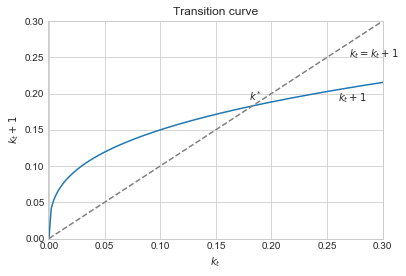

In [135]:
# Call transition curve function
capital_1,capital_2 = transition_curve(alpha,rho,n)

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(capital_1,capital_2)
ax.plot(capital_1,capital_1, '--', color='grey')
plt.text(0.26,0.19,'$k_t+1$')
plt.text(0.27,0.25,'$k_t=k_t+1$')
plt.text(0.18,0.19,'$k^*$')
ax.set_xlabel('$k_t$')
ax.set_ylabel('$k_t+1$')
ax.set_title('Transition curve')
ax.set_xlim([-0.001,0.3])
ax.set_ylim([0,0.3]);

The transition curve and the 45 degrees curve representing $k_t+1 = k_t$ intersect at the steady state level of capital $k^*$.

# Dynamics with CRRA utility

We now introduce CRRA utility, where $u(c)$ is given by the CRRA utility function: 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log (c), & \sigma = 1
  \end{cases}
\end{equation}

where $\sigma$ is the degree of relative risk aversion, which is constant.

This imply that the Euler equation is given by: 

$$ c_{2t+1} = \left(\frac{1+r_{t+1}}{1+\rho}\right)^\frac{1}{\sigma} c_{1t} $$

Inserting the budget constraint and solve for s, optimal savings is given by: 

$$ s_t = \frac{1}{(1+r_{t+1})^\frac{\sigma-1}{\sigma}(1+\rho)^\frac{1}{\sigma} +1} w_t $$

where the wage and the interest rate is given by: 

$$ w_t = (1-\alpha)k_t^\alpha $$

$$ r_{t} = \alpha k_{t}^{\alpha-1} $$

We now want to see how the transitionscurve behaves for different values of $\sigma$. 

First, we define the functions needed to derive the transition curve with CRRA utility:

In [136]:
def savings2(w,r,rho,sigma):
    return (1/((1+r)**((sigma-1)/sigma)*(1+rho)**(1/sigma)+1))*w

def transition2(k,alpha,sigma,rho,n):
    w = wage(k,alpha)
    r = rr(k,alpha) 
    s = savings2(w,r,rho,sigma)
    return capital_2t(s,n)

def transition_curve(alpha,rho,n):

    # a. grids
    capital_1 = np.linspace(1e-8,1,500)
    capital_2 = np.empty(500)

    #b. solve for each k in grid
    for i,k in enumerate(capital_1):
    
        # i. capital in t+1
         result = transition2(k,alpha,sigma,rho,n)
         capital_2[i] = result

    return capital_1,capital_2

Now we derive transition curves for different values of $\sigma$ and plot these in a transition diagram:

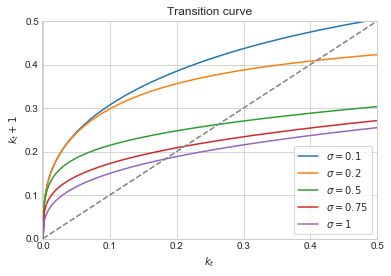

In [137]:
# Make a plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Transition curves
for sigma in [0.1,0.2,0.5,0.75,1]:
    capital_1,capital_2 = transition_curve(alpha,rho,n)
    ax.plot(capital_1,capital_2,label=f'$\sigma = {sigma}$')

# Plot transition curves
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.plot(capital_1,capital_1, '--', color='grey')
ax.set_xlabel('$k_t$')
ax.set_ylabel('$k_t+1$')
ax.set_title('Transition curve')
ax.set_xlim([-0.001,0.5])
ax.set_ylim([0,0.5]);

We see that the higher $\sigma$ the lower capital accumulation. This is a consequence of individuals saving less when $\sigma$ is high. $1/\sigma$ is the elasticity of intertemporal substitution, thus the higher $\sigma$ the less are individuals willing to substitute consumption over time, and the less they save. 

# PAYG System

We now introduce a social security system to the model. We assume that the government raises $d_t$ from the current young in period t and pays them out as benefits to current old:

$$(1+n)d_t = b_t$$

where $d_t$ is a fixed fraction of the wage income, such that: $d_t=\tau w_{t}$.


Thus we get a new budget constraint for the young in period t:

$$ c_{1t} + s_t + d_t = w_t$$

and a new budget constraint for them when old in period t+1 given by:
$$ c_{2t+1} = (1+r_{t+1})s_t + (1+n)d_{t+1} $$

We return to the case where utility $u(c)=log(c)$ and consider the transition curve for different values of $\tau$.  

The savings equation will then be given by: 

$$ s_t = \frac{1}{2+\rho} \left[(w_t-d_t) - \frac{1+\rho}{1+r_{t+1}} (1+n) d_{t+1}\right]$$


We define the functions for $d_t$, savings $s_t$ and the transition curve.

In [141]:
tau = 0.3

def d1(w,tau):
    return tau*w

def savings(w,rho,d,r,n):
    return (1/(2+rho))*((w-d)-((1+rho/(1+r))*(1+n)*d))

def transition(k,alpha,rho,n,tau):
    w = wage(k,alpha)
    d = d1(w,tau)
    r = rr(k,alpha)
    s = savings(w,rho,d,r,n)
    return capital_2t(s,n)

We define the new function for the transition curve

In [142]:
def transition_curve(alpha,rho,n,tau):

    # Grids
    capital_1 = np.linspace(1e-8,1,500)
    capital_2 = np.empty(500)

    # Solve for each k in grid
    for i,k in enumerate(capital_1):
        
        # Capital in t+1
        result = transition(k,alpha,rho,n,tau)
        capital_2[i] = result

    return capital_1,capital_2

capital_3,capital_4 = transition_curve(alpha,rho,n,tau)

We construct a plot of the PAYG transition curve with a slider, which can be used to investigate the effect of different values of $\tau$.

In [143]:
def fig(alpha, rho, n, tau):
    capital_3,capital_4 = transition_curve(alpha,rho,n,tau)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(capital_3,capital_4, label=f'PAYG')
    ax.plot(capital_1,capital_2, label=f'Simple')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.plot(capital_3,capital_3,'--',color='grey')
    ax.plot(capital_3,np.zeros(len(capital_3)), 'black')
    ax.set_xlabel('$k_t$')
    ax.set_ylabel('$k_t+1$')
    ax.set_title('Transition curve')
    ax.set_xlim([-0.001,0.3])
    ax.set_ylim([-0.05,0.3]);

    return   
    
import ipywidgets as widgets
widgets.interact(fig,
    alpha = widgets.fixed(alpha), 
    rho = widgets.fixed(rho),
    n = widgets.fixed(n),
    tau=widgets.FloatSlider(description='t', min=0, max=1, step=0.01, value=0.1),
);       

interactive(children=(FloatSlider(value=0.1, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

We see that the higher $\tau$ the lower capital accumulation, which is due to individuals saving less. For $\tau > 0.49$ individuals will not save anything of their labor income.   

## Steady State Values 

We now want to find optimal capital in steady state $k^*$ and derive the steady state values for $s^*, w^* c_{1t}^*, c_{2t+1}^*, U^*$. $\sigma$ is assumed to be 1 which once again implies $u(c)=log (c)$.

In [100]:
# Savings as a function of capital 
#def func(k,rho,alpha,n):
    #return -k + ((1/(2+rho)*(1-alpha)*k**alpha)*(1/(1+n)))

obj = lambda k: -k + ((1/(2+rho)*(1-alpha)*k**alpha)*(1/(1+n)))

# Objective function
#def objective(k,rho,alpha,n):
    #return -func(k)

We define a function, which call an optimizer in order to find optimal k and thereby optimal s, w, c1, c2 and lifetime utility for the individual and print these.

In [112]:
result = optimize.root_scalar(obj,bracket = [1e-8,1],method='brentq')

kstar = result.root
wstar = (1-alpha)*kstar**alpha
sstar = kstar/(1+n)
c1star = wstar-sstar
c2star = (1+(alpha*kstar**alpha))*sstar 
Ustar = c1star + (1/(1+rho))*c2star

print(f'k* = {kstar:.4f}')
print(f'w* = {wstar:.4f}')
print(f's* = {sstar:.4f}')
print(f'c1* = {c1star:.4f}')
print(f'c2* = {c2star:.4f}')
print(f'U* = {Ustar:.4f}')


k* = 0.1829
w* = 0.3825
s* = 0.1793
c1* = 0.2032
c2* = 0.2131
U* = 0.4061


In [129]:
tau = 0.1
obj2 = lambda k: -k + (1/(2+rho))*((k**alpha-tau*k**alpha)-((1+rho/(1+(1-alpha)*k**(alpha-1)))*(1+n)*tau*k**alpha))

result2 = optimize.root_scalar(obj2,bracket = [1e-8,1],method='brentq')

kstar = result2.root
wstar = (1-alpha)*kstar**alpha
rstar = alpha*k**(alpha-1)
sstar = kstar/(1+n)
c1star = wstar-sstar-wstar*tau
c2star = (1+(alpha*kstar**alpha))*sstar + (1+n)*wstar*tau
Ustar = c1star + (1/(1+rho))*c2star
print(f'k* = {kstar:.4f}')
print(f'w* = {wstar:.4f}')
print(f's* = {sstar:.4f}')
print(f'c1* = {c1star:.4f}')
print(f'c2* = {c2star:.4f}')
print(f'U* = {Ustar:.4f}')

k* = 0.2437
w* = 0.4205
s* = 0.2390
c1* = 0.1395
c2* = 0.3313
U* = 0.4550


# Conclusion

ADD CONCISE CONCLUSION.